## **KMedians Clustering**

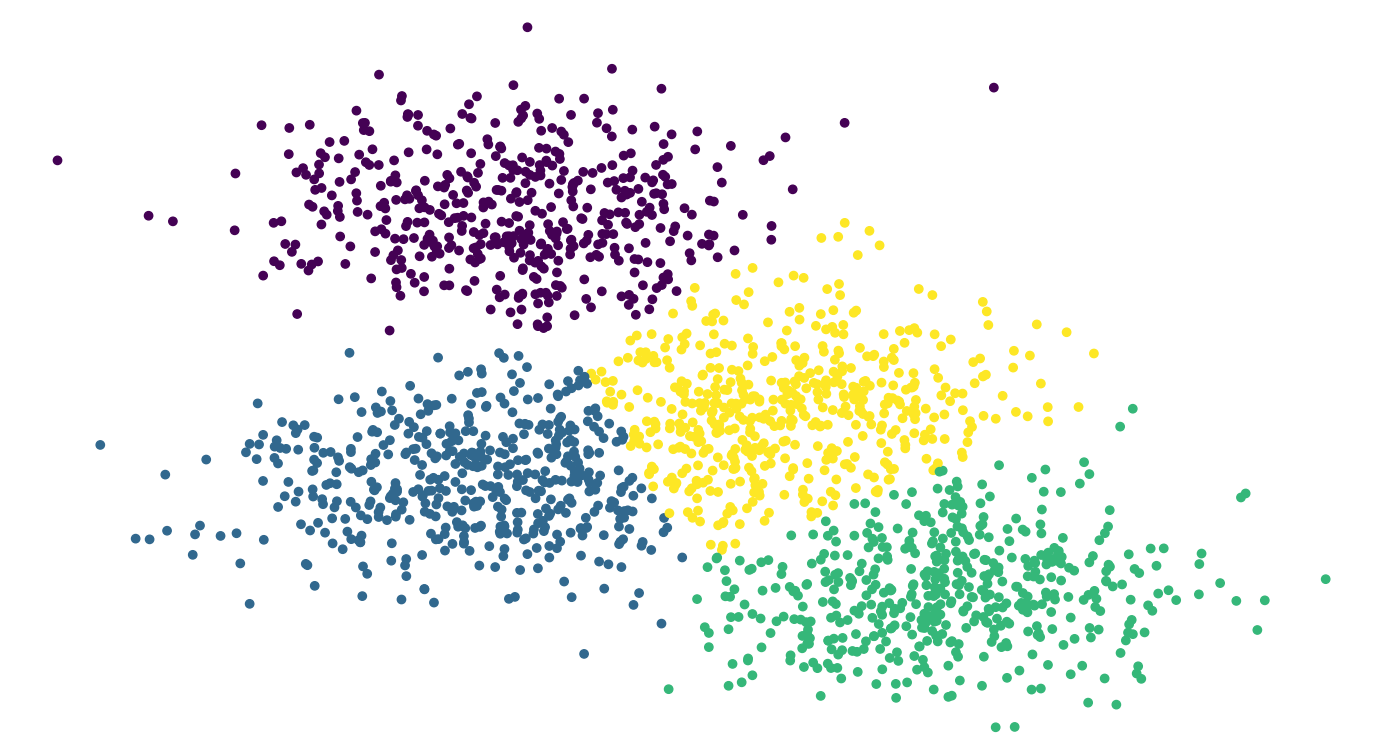

The algo is similar to Kmeans

Let's look into it.

## Algorithm

**STEP 1: Initialization**

First, we initialize the cluster centers. (another name for centroids)

**STEP 2: Repeat until convergence**

$ $

1. Assignment
    - each of the point is assigned to the closest cluster

2. Update cluster center


For Kmeans,
-  centroid update equation was: $C_j = \frac{1}{|S_j|} * Σ_{x_i∈S_j} x_i$
- i.e. taking the mean of all the points belonging to the cluster to compute new centroid.
    
In Kmedian,
- instead of find the mean, we find the median.

#### Why Kmedian is less sensitive to outliers ?

Since we are using median to find the updated cluster center,
- and median is less sensitive to outliers as compared to mean

This makes Kmedians less sensitive to outlier

## Objective Function

Given a set of observations $\left(\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n\right)$, where each observation is a $d$-dimensional real vector, $k$-means clustering aims to partition the $n$ observations into $k(\leq n)$ sets $\mathbf{S}=\left\{S_1, S_2, \ldots, S_k\right\}$ so as to minimize the within-cluster sum of Manhattan distances from the cluster center.

**Loss Function** $=\sum_{i=1}^k \sum_{\mathbf{x} \in S_i}\left\|\mathbf{x}-\boldsymbol{C}_i\right\|_1$\
where $C_i$ is the median of points in $S_i$

##  

##  

##  

##  

In [ ]:
class my_KMedians:

  @classmethod
  def get_label(cls, pt, cluster_centers, dist_metric):
    if dist_metric == 'euclidean':
      cluster_dist = np.sqrt(np.sum((pt - cluster_centers) ** 2, axis = 1))
    else:
      cluster_dist = np.sum(np.abs(pt - cluster_centers), axis = 1)
    return np.argmin(cluster_dist)

  @classmethod
  def check_random_state(cls, random_state):
    from sklearn.utils import check_random_state
    return check_random_state(random_state)

  @classmethod
  def sample_without_replacement(cls, n_population, n_samples, random_state_):
    from sklearn.utils.random import sample_without_replacement
    return sample_without_replacement(n_population = n_population, n_samples = n_samples, random_state = random_state_)


  def __init__(self, init = 'random', n_init = 1, initial_medians = [], n_clusters = 4, itermax = 300, random_state = 1, dist_metric = 'manhattan'):
    import warnings
    if len(initial_medians) == 0:
      if init not in {'random', 'k-medians++'}:
        raise Exception('The argument for initialization method i.e. init must be either "random" or "k-medians++" or "initial_medians" should be passed as argument')
      else:
        self.init = init
        self.initial_medians = initial_medians
        self.n_clusters= n_clusters
        self.n_init = n_init
    else:
      if init not in {'random', 'k-medians++'}:
        raise Exception(f'{init} is an invalid argument for "init"')
      elif init == 'k-medians++':
        raise Exception(f"'{init}' is an invalid argument for 'init' with initial medians passed.")
      else:
        warnings.warn("Warning: Setting initialization in accordance with the 'initial_medians' passed as argument")
        warnings.warn("Warning: Setting number of initiliazations i.e. 'n_init' to 1 as 'initial_medians' are passed as argument")
      self.initial_medians = np.array(initial_medians)
      self.init = 'Explicit initialization'
      self.n_clusters = (self.initial_medians).shape[0]
      self.n_init = 1

    self.itermax = itermax
    self.random_state = random_state
    if dist_metric not in {'euclidean', 'manhattan'}:
      raise Exception(f'{dist_metric} is an invalid argument for "dist_metric". It should be either "euclidean" or "manhattan"')
    else:
      self.dist_metric = dist_metric


  def fit(self, X):
    import numpy as np
    if len(self.initial_medians) > 0 and (self.initial_medians).shape[1] != X.shape[1]:
      raise Exception("The dimensions of the initialized cluster centers doesn't match with the dimensions of the data")
    n, d = X.shape
    random_state = self.check_random_state(self.random_state)
    final_cluster_centers = None
    final_labels = None
    least_inertia = np.inf

    for iter_ in range(self.n_init):

      if self.init == 'random':
        cluster_centers_indexes = my_KMedians.sample_without_replacement(n_population = n, n_samples = self.n_clusters, random_state_ = random_state)
        cluster_centers = X[cluster_centers_indexes, :]

      elif  self.init == 'k-medians++':
        cluster_centers_indexes = my_KMedians.sample_without_replacement(n_population = n, n_samples = 1, random_state_ = random_state)
        cluster_centers = X[cluster_centers_indexes, :]
        while len(cluster_centers_indexes) < self.n_clusters:
          nearest_cluster_center_dist_sq = np.array([])
          for i, pt in enumerate(X):
            cluster_center_dist_sq = np.sum((pt - cluster_centers) ** 2, axis = 1)
            min_cluster_center_dist_sq = min(cluster_center_dist_sq)
            nearest_cluster_center_dist_sq = np.append(nearest_cluster_center_dist_sq, min_cluster_center_dist_sq)
          cluster_center_probas = nearest_cluster_center_dist_sq/np.sum(nearest_cluster_center_dist_sq)
          cluster_center_index = np.random.choice(range(n), p = cluster_center_probas)
          cluster_center = X[[cluster_center_index]]
          while cluster_center_index in cluster_centers_indexes:
            rand_prob = np.random.rand()
            cluster_center_index = np.random.choice(range(n), p = cluster_center_probas)
            cluster_center = X[[cluster_center_index]]

          cluster_centers_indexes = np.append(cluster_centers_indexes, cluster_center_index)
          cluster_centers = np.vstack((cluster_centers, cluster_center))
      else:
        cluster_centers = self.initial_medians

      labels = np.zeros(n,)
      for i in range(self.itermax):
        for idx, pt in enumerate(X):
          cluster_label = my_KMedians.get_label(pt, cluster_centers, self.dist_metric)
          labels[idx] = cluster_label
        for label in range(self.n_clusters):
          cluster_pts = X[labels == label]
          cluster_centers[label, :] = np.median(cluster_pts, axis = 0)

      inertia = 0
      for label, cluster_center in enumerate(cluster_centers):
        cluster_pts = X[labels == label]
        if self.dist_metric == 'euclidean':
          inertia += np.sum(np.sum((cluster_pts - cluster_center) ** 2, axis = 1))
        else:
          inertia += np.sum(np.abs(cluster_pts - cluster_center))
      if inertia < least_inertia:
        least_inertia = inertia
        final_cluster_centers = cluster_centers
        final_labels = labels
    self.labels_ = final_labels
    self.cluster_centers_ = final_cluster_centers
    self.inertia_ = least_inertia











  def predict(self, X):
    if 'labels_' not in dir(self):
      raise Exception("The model has not been fit on data yet")
    import numpy as np
    n = X.shape[0]
    labels = np.zeros(n,)

    for idx, pt in enumerate(X):
      cluster_label = my_KMedians.get_label(pt, self.cluster_centers_, self.dist_metric)
      labels[idx] = cluster_label
    return labels


  def fit_predict(self, X):
    import numpy as np
    self.fit(X)
    return self.labels_